In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 594ms/step - loss: 5.5363e-05
Average validation loss: 0.09492258727550507
4/4 [==============================] - 6s 608ms/step - loss: 5.5363e-05 - val_loss: 0.0949
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 602ms/step - loss: 5.2844e-05 - val_loss: 0.0949
Average validation loss: 0.08608907461166382
4/4 [==============================] - 8s 615ms/step - loss: 5.2844e-05 - val_loss: 0.0905
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 613ms/step - loss: 5.3598e-05 - val_loss: 0.0905
Average validation loss: 0.08178790658712387
4/4 [==============================] - 11s 629ms/step - loss: 5.3598e-05 - val_loss: 0.0876
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 712ms/step - loss: 1.0828e-04
Average validation loss: 0.03129038028419018
8/8 [==============================] - 6s 728ms/step - loss: 1.0828e-04 - val_loss: 0.0313
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 721ms/step - loss: 1.0825e-04 - val_loss: 0.0313
Average validation loss: 0.0012382055283524096
8/8 [==============================] - 12s 736ms/step - loss: 1.0825e-04 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 719ms/step - loss: 1.0791e-04 - val_loss: 0.0163
Average validation loss: 0.038929130882024765
8/8 [==============================] - 18s 733ms/step - loss: 1.0791e-04 - val_loss: 0.0238
Epoch 4/10
8/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 720ms/step - loss: 1.4152e-04
Average validation loss: 0.009068483021110296
12/12 [==============================] - 9s 731ms/step - loss: 1.4152e-04 - val_loss: 0.0091
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 720ms/step - loss: 1.3602e-04 - val_loss: 0.0091
Average validation loss: 0.0370088629424572
12/12 [==============================] - 18s 730ms/step - loss: 1.3602e-04 - val_loss: 0.0230
Epoch 3/10
12/12 [==============================] - 27s 755ms/step - loss: 1.4174e-04 - val_loss: 0.0230
Average validation loss: 0.0061999457733084755
12/12 [==============================] - 27s 766ms/step - loss: 1.4174e-04 - val_loss: 0.0174
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_15.pth'.
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 727ms/step - loss: 1.2908e-04
Average validation loss: 0.01146517969755223
16/16 [==============================] - 12s 741ms/step - loss: 1.2908e-04 - val_loss: 0.0115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 728ms/step - loss: 1.3438e-04 - val_loss: 0.0115
Average validation loss: 0.09550830535590649
16/16 [==============================] - 24s 739ms/step - loss: 1.3438e-04 - val_loss: 0.0535
Epoch 3/10
16/16 [==============================] - 35s 717ms/step - loss: 1.3241e-04 - val_loss: 0.0535
Average validation loss: 0.01692108321003616
16/16 [==============================] - 36s 731ms/step - loss: 1.3241e-04 - val_loss: 0.0413
Epoch 4/10
16/16 [==============================] - 47s 716ms/step - loss: 1.3117e-04 - val_loss: 0.0413
Average validation loss: 0.032762615010142326

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 720ms/step - loss: 1.0175e-04
Average validation loss: 0.06115259137004614
20/20 [==============================] - 15s 732ms/step - loss: 1.0175e-04 - val_loss: 0.0612
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 717ms/step - loss: 1.0403e-04 - val_loss: 0.0612
Average validation loss: 0.053361800871789454
20/20 [==============================] - 29s 727ms/step - loss: 1.0403e-04 - val_loss: 0.0573
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 717ms/step - loss: 1.1774e-04 - val_loss: 0.0573
Average validation loss: 0.08295187652111054
20/20 [==============================] - 44s 729ms/step - loss: 1.1774e-04 - val_loss: 0.0658
E

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 714ms/step - loss: 9.4244e-05
Average validation loss: 0.10889337584376335
24/24 [==============================] - 17s 725ms/step - loss: 9.4244e-05 - val_loss: 0.1089
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 721ms/step - loss: 9.0568e-05 - val_loss: 0.1089
Average validation loss: 0.08609830091396968
24/24 [==============================] - 35s 732ms/step - loss: 9.0568e-05 - val_loss: 0.0975
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 722ms/step - loss: 9.1536e-05 - val_loss: 0.0975
Average validation loss: 0.09736114988724391
24/24 [==============================] - 53s 735ms/step - loss: 9.1536e-05 - val_loss: 0.0975
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 712ms/step - loss: 8.8476e-05
Average validation loss: 0.0917942114174366
40/40 [==============================] - 29s 724ms/step - loss: 8.8476e-05 - val_loss: 0.0918
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 729ms/step - loss: 8.7508e-05 - val_loss: 0.0918
Average validation loss: 0.09643844738602639
40/40 [==============================] - 59s 742ms/step - loss: 8.7508e-05 - val_loss: 0.0941
Epoch 3/10
40/40 [==============================] - 87s 714ms/step - loss: 8.5113e-05 - val_loss: 0.0941
Average validation loss: 0.0970405749976635
40/40 [==============================] - 88s 727ms/step - loss: 8.5113e-05 - val_loss: 0.0951
Epoch 4/10
40/40 [==============================] - 116s 716ms/step - loss: 8.3683e-05 - val_loss: 0.0951
Average validation loss: 0.0524767704308033
40

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 717ms/step - loss: 6.8298e-05
Average validation loss: 0.0734986681685162
48/48 [==============================] - 35s 729ms/step - loss: 6.8298e-05 - val_loss: 0.0735
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 715ms/step - loss: 7.1624e-05 - val_loss: 0.0735
Average validation loss: 0.06901368886853258
48/48 [==============================] - 70s 727ms/step - loss: 7.1624e-05 - val_loss: 0.0713
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 717ms/step - loss: 6.9746e-05 - val_loss: 0.0713
Average validation loss: 0.06826287127720813
48/48 [==============================] - 105s 729ms/step - loss: 6.9746e-05 - val_loss: 0.0703
S

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 721ms/step - loss: 6.4355e-05
Average validation loss: 0.06498657995169717
56/56 [==============================] - 41s 733ms/step - loss: 6.4355e-05 - val_loss: 0.0650
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 718ms/step - loss: 6.3108e-05 - val_loss: 0.0650
Average validation loss: 0.07449115829409234
56/56 [==============================] - 82s 730ms/step - loss: 6.3108e-05 - val_loss: 0.0697
Epoch 3/10
56/56 [==============================] - 122s 714ms/step - loss: 6.2723e-05 - val_loss: 0.0697
Average validation loss: 0.074506690459592
56/56 [==============================] - 123s 726ms/step - loss: 6.2723e-05 - val_loss: 0.0713
Epoch 4/10
56/56 [==============================] - 163s 719ms/step - loss: 6.1039e-05 - val_loss: 0.0713
Average validation loss: 0.0738165442432676


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 720ms/step - loss: 5.4585e-05
Average validation loss: 0.08730104460846633
64/64 [==============================] - 47s 731ms/step - loss: 5.4585e-05 - val_loss: 0.0873
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 724ms/step - loss: 5.3186e-05 - val_loss: 0.0873
Average validation loss: 0.0841911273309961
64/64 [==============================] - 94s 735ms/step - loss: 5.3186e-05 - val_loss: 0.0857
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 715ms/step - loss: 5.3342e-05 - val_loss: 0.0857
Average validation loss: 0.0892178239300847
64/64 [==============================] - 141s 726ms/step - loss: 5.3342e-05 - val_loss: 0.0869
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 715ms/step - loss: 4.0402e-05
Average validation loss: 0.09180506898297204
72/72 [==============================] - 52s 726ms/step - loss: 4.0402e-05 - val_loss: 0.0918
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 719ms/step - loss: 3.8159e-05 - val_loss: 0.0918
Average validation loss: 0.09147304130925073
72/72 [==============================] - 105s 731ms/step - loss: 3.8159e-05 - val_loss: 0.0916
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 730ms/step - loss: 3.9172e-05 - val_loss: 0.0916
Average validation loss: 0.08377342629763815
72/72 [==============================] - 159s 741ms/step - loss: 3.9172e-05 - val_loss: 0.089

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 717ms/step - loss: 3.5558e-05
Average validation loss: 0.06412011478096247
80/80 [==============================] - 58s 728ms/step - loss: 3.5558e-05 - val_loss: 0.0641
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 726ms/step - loss: 3.5300e-05 - val_loss: 0.0641
Average validation loss: 0.09138761013746262
80/80 [==============================] - 117s 737ms/step - loss: 3.5300e-05 - val_loss: 0.0778
Epoch 3/10
80/80 [==============================] - 175s 719ms/step - loss: 3.4861e-05 - val_loss: 0.0778
Average validation loss: 0.09477418512105942
80/80 [==============================] - 176s 731ms/step - loss: 3.4861e-05 - val_loss: 0.0834
Epoch 4/10
80/80 [==============================] - 233s 718ms/step - loss: 3.3555e-05 - val_loss: 0.0834
Average validation loss: 0.096568457037

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 719ms/step - loss: 3.7198e-05
Average validation loss: 0.09187599613020818
96/96 [==============================] - 70s 730ms/step - loss: 3.7198e-05 - val_loss: 0.0919
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 718ms/step - loss: 3.4756e-05 - val_loss: 0.0919
Average validation loss: 0.0892477547749877
96/96 [==============================] - 140s 730ms/step - loss: 3.4756e-05 - val_loss: 0.0906
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 721ms/step - loss: 3.3930e-05 - val_loss: 0.0906
Average validation loss: 0.09331971189628045
96/96 [==============================] - 210s 731ms/step - loss: 3.3930e-05 - val_loss: 0.09

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 720ms/step - loss: 5.4286e-05
Average validation loss: 0.0948097741852204
120/120 [==============================] - 88s 733ms/step - loss: 5.4286e-05 - val_loss: 0.0948
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 714ms/step - loss: 4.9995e-05 - val_loss: 0.0948
Average validation loss: 0.09196876001854738
120/120 [==============================] - 175s 725ms/step - loss: 4.9995e-05 - val_loss: 0.0934
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 260s 707ms/step - loss: 5.0683e-05 - val_loss: 0.0934
Average validation loss: 0.09301556448141733
120/120 [==============================] - 261s 719ms/step - loss: 5.0683e-05 - va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 713ms/step - loss: 5.6635e-05
Average validation loss: 0.09548601901365651
144/144 [==============================] - 104s 725ms/step - loss: 5.6635e-05 - val_loss: 0.0955
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 207s 715ms/step - loss: 5.1463e-05 - val_loss: 0.0955
Average validation loss: 0.10270638267199199
144/144 [==============================] - 209s 726ms/step - loss: 5.1463e-05 - val_loss: 0.0991
Epoch 3/10
144/144 [==============================] - 312s 716ms/step - loss: 4.8692e-05 - val_loss: 0.0991
Average validation loss: 0.09787238999787304
144/144 [==============================] - 314s 728ms/step - loss: 4.8692e-05 - val_loss: 0.0987
Epoch 4/10
144/144 [==============================] - 417s 715ms/step - loss: 4.6980e-05 - val_loss: 0.0987
Average validation loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 719ms/step - loss: 4.5491e-05
Average validation loss: 0.10051322150975465
160/160 [==============================] - 117s 730ms/step - loss: 4.5491e-05 - val_loss: 0.1005
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 712ms/step - loss: 4.2699e-05 - val_loss: 0.1005
Average validation loss: 0.09671197440475225
160/160 [==============================] - 233s 723ms/step - loss: 4.2699e-05 - val_loss: 0.0986
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 347s 712ms/step - loss: 4.0910e-05 - val_loss: 0.0986
Average validation loss: 0.08843017481267453
160/160 [==============================] - 349s 724ms/step - loss: 4.0910e-05 -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 715ms/step - loss: 5.2298e-05
Average validation loss: 0.10474848568439483
200/200 [==============================] - 145s 727ms/step - loss: 5.2298e-05 - val_loss: 0.1047
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 718ms/step - loss: 4.7655e-05 - val_loss: 0.1047
Average validation loss: 0.10094097465276718
200/200 [==============================] - 291s 730ms/step - loss: 4.7655e-05 - val_loss: 0.1028
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 714ms/step - loss: 4.5166e-05 - val_loss: 0.1028
Average validation loss: 0.09699311941862106
200/200 [==============================] - 437s 725ms/step - loss: 4.5166e-05 -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 5.0146e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 717ms/step - loss: 5.2539e-05
Average validation loss: 0.10032421114544074
240/240 [==============================] - 175s 729ms/step - loss: 5.2539e-05 - val_loss: 0.1003
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 714ms/step - loss: 4.8719e-05 - val_loss: 0.1003
Average validation loss: 0.0993026465177536
240/240 [==============================] - 349s 725ms/step - loss: 4.8719e-05 - val_loss: 0.0998
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_100\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 520s 714ms/step - loss: 4.4766e-05 - val_loss: 0.0998
Average validation loss: 0.10354378515233596
240/240 [==============================] - 523s 726ms/step - loss: 4.4766e-05 - 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.03904258198046591, 0.02242500070447477, 0.02913527324407672, 0.050784143266755566, 0.0678786108327913, 0.06678495397015163, 0.07688020657550078, 0.07937696149587282, 0.08338655128476341, 0.08613646804180462, 0.08767923486315542, 0.0921433520000428, 0.09138896833639593, 0.0919133531736831, 0.09695650822483003, 0.0968521338487044, 0.09777051259726285, 0.10027668266867597]
std_val_losses =  [0.02615591507145083, 0.017496206579181817, 0.0247393103679801, 0.026129221794537284, 0.023222945639659983, 0.02926789382963958, 0.013670708720431081, 0.013303564951570115, 0.00737195359481169, 0.006100537678938791, 0.00717343401625941, 0.007006793590250171, 0.007159153257191091, 0.00795092826344149, 0.007297335016603058, 0.008671456422186894, 0.006548996057845418, 0.006530657828080612]


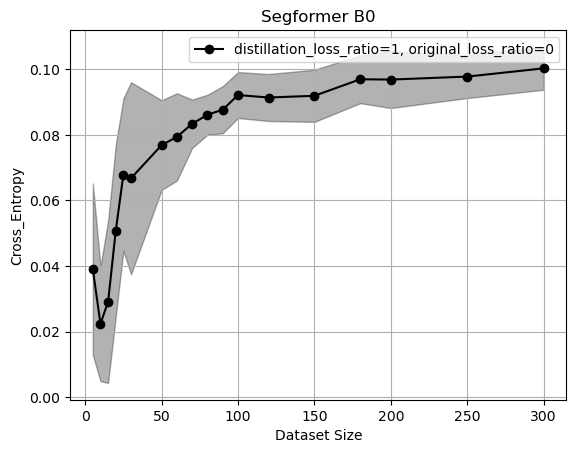

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()